In [1]:
import os 
os.chdir("Images")
os.listdir()

['.DS_Store', 'Experiment10', 'Experiment7', 'Experiment4']

In [2]:
import vtk
mt = vtk.vtkMathTextUtilities.GetInstance()
print("VTK MathText available:", bool(mt) and mt.IsAvailable())


VTK MathText available: True


In [3]:
import sys

target_src = "/Users/hakanakgun/Desktop/Projects/ProfLeeProjects/Knotted_Graphs/Results/Lifshitz_Transition/UpdateGit/KnottedGraph/src"
if target_src not in sys.path:
    sys.path.insert(0, target_src)

import knotted_graph
print(knotted_graph.__file__)


/Users/hakanakgun/Desktop/Projects/ProfLeeProjects/Knotted_Graphs/Results/KnottedGraphLatestGitPull/src/knotted_graph/__init__.py


In [4]:
from pathlib import Path
from typing import Any, Callable, Dict, List, Tuple, Union
import fitz  # PyMuPDF
import pyvista as pv
import numpy as np
import sympy as sp
import matplotlib as mpl
import ast
from matplotlib.colors import ListedColormap, BoundaryNorm


import vtkmodules.vtkRenderingFreeType
import vtkmodules.vtkRenderingMatplotlib
 
knot_green = "#15B448"
knot_blue = "#348ABD"
knot_red = "#A60628"

color_0 = "#208D8E"
color_1 = "#7F9720"
color_2 = "#E85C06"
color_3 = "#CE1C8A"
 
import os 
from knotted_graph.NodalSkeletonMultiBand import NodalSkeletonMultiBand  
 


def configure_matplotlib_rcparams() -> None:
    mpl.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{newtxtext,newtxmath}",  
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "svg.fonttype": "none",
        "axes.labelsize": 18,
        "axes.labelweight": "bold",
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    })
 

configure_matplotlib_rcparams() 
  

AXES_PAD_FRAC       = 0.08
AXES_FONT_SIZE      = 22
AXES_SCREEN_SIZE    = 22
AXES_TITLE_FONT     = 28
AXES_LABEL_FONT     = 22
AXES_LABEL_OFFSET   = -45
AXES_TITLE_OFFSET   = (-8, -8)
SHOW_TICK_LABELS    = False

def padded_bounds(bounds, pad_frac=AXES_PAD_FRAC):
    xmin, xmax, ymin, ymax, zmin, zmax = map(float, bounds)
    dx, dy, dz = (xmax - xmin), (ymax - ymin), (zmax - zmin)
    p = float(pad_frac) * max(dx, dy, dz, 1e-9)
    return (xmin - p, xmax + p, ymin - p, ymax + p, zmin - p, zmax + p)
def apply_bounds_style(
    pl,
    *,
    bounds_override=None,          # <-- NEW
    pad_frac=AXES_PAD_FRAC,
    screen_size=AXES_SCREEN_SIZE,
    title_font_size=AXES_TITLE_FONT,
    label_font_size=AXES_LABEL_FONT,
    font_size=AXES_FONT_SIZE,
    label_offset=AXES_LABEL_OFFSET,
    title_offset=AXES_TITLE_OFFSET,
    show_tick_labels=SHOW_TICK_LABELS,
):
    # Use provided bounds if given; otherwise use plotter bounds
    base_bounds = bounds_override if bounds_override is not None else pl.bounds
    axes_bounds = padded_bounds(base_bounds, pad_frac=pad_frac)

    axes = pl.show_bounds(
        bounds=axes_bounds,
        location="outer",
        all_edges=False,
        xtitle=r"$k_x$",
        ytitle=r"$k_y$",
        ztitle=r"$k_z$",
        show_xlabels=show_tick_labels,
        show_ylabels=show_tick_labels,
        show_zlabels=show_tick_labels,
        font_size=font_size,
        ticks="inside",
        use_3d_text=True,
    )

    axes.SetScreenSize(screen_size)
    axes.label_offset = label_offset
    axes.title_offset = title_offset

    for i in (0, 1, 2):
        tp = axes.GetTitleTextProperty(i)
        tp.SetFontFamilyToTimes()
        tp.BoldOn()
        tp.SetFontSize(int(title_font_size))
        tp.SetColor(0, 0, 0)

        lp = axes.GetLabelTextProperty(i)
        lp.SetFontFamilyToTimes()
        lp.SetFontSize(int(label_font_size))
        lp.SetColor(0, 0, 0)

    return axes
 
def autocrop_pdf_whitespace_mupdf(
    pdf_path: Path,
    margin: float = 0.02,
    use_fraction: bool = True,
    zoom: float = 2.0,
    white_thresh: int = 245,
    out_pdf: Path | None = None,
) -> Path:
    pdf_path = Path(pdf_path)
    if out_pdf is None:
        out_pdf = pdf_path.with_name(pdf_path.stem + "_cropped.pdf")

    src = fitz.open(str(pdf_path))
    dst = fitz.open()

    for pno in range(src.page_count):
        page = src[pno]
        pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), alpha=False)
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)[..., :3]

        gray = img.mean(axis=2)
        mask = gray < white_thresh
        if not mask.any():
            new_page = dst.new_page(width=page.rect.width, height=page.rect.height)
            new_page.show_pdf_page(new_page.rect, src, pno)
            continue

        ys, xs = np.where(mask)
        left, right = xs.min(), xs.max() + 1
        upper, lower = ys.min(), ys.max() + 1

        content_w = right - left
        content_h = lower - upper
        pad_px = int(min(content_w, content_h) * margin) if use_fraction else int(margin)

        left  = max(0, left  - pad_px)
        upper = max(0, upper - pad_px)
        right = min(pix.width,  right + pad_px)
        lower = min(pix.height, lower + pad_px)

        crop = fitz.Rect(left/zoom, upper/zoom, right/zoom, lower/zoom) & page.rect

        new_page = dst.new_page(width=crop.width, height=crop.height)
        new_page.show_pdf_page(new_page.rect, src, pno, clip=crop)

    dst.save(str(out_pdf), garbage=4, deflate=True)
    dst.close()
    src.close()
    return out_pdf


def rasterize_pdf_to_small_pdf(
    in_pdf: str,
    out_pdf: str,
    dpi: int = 200,
    jpeg_quality: int = 75,
):
    """
    Rasterize each page of `in_pdf` to a JPEG at `dpi`, then embed into a new PDF.
    Lower dpi / lower jpeg_quality => smaller output size.
    """
    src = fitz.open(in_pdf)
    dst = fitz.open()

    zoom = dpi / 72.0
    mat = fitz.Matrix(zoom, zoom)

    for i in range(src.page_count):
        page = src.load_page(i)
        rect = page.rect

        pix = page.get_pixmap(matrix=mat, alpha=False)  # alpha=False -> smaller
        jpg_bytes = pix.tobytes("jpg", jpg_quality=jpeg_quality)

        new_page = dst.new_page(width=rect.width, height=rect.height)
        new_page.insert_image(rect, stream=jpg_bytes)

    dst.save(out_pdf, deflate=True, garbage=4, clean=True)
    dst.close()
    src.close()

def compress_raster_pdf_to_target_mb(
    in_pdf: str,
    out_pdf: str,
    target_mb: float = 0.2,
    start_dpi: int = 220,
    start_quality: int = 80,
):
    """
    Attempts to hit `target_mb` by stepping down DPI then JPEG quality.
    Produces `out_pdf` as the final result.
    """
    tmp_out = out_pdf

    dpi = start_dpi
    q = start_quality

    # First: decrease DPI
    for _ in range(6):
        rasterize_pdf_to_small_pdf(in_pdf, tmp_out, dpi=dpi, jpeg_quality=q)
        size_mb = os.path.getsize(tmp_out) / (1024 * 1024)
        if size_mb <= target_mb:
            return size_mb, dpi, q
        dpi = max(120, int(dpi * 0.85))

    # Then: decrease quality
    for _ in range(8):
        rasterize_pdf_to_small_pdf(in_pdf, tmp_out, dpi=dpi, jpeg_quality=q)
        size_mb = os.path.getsize(tmp_out) / (1024 * 1024)
        if size_mb <= target_mb:
            return size_mb, dpi, q
        q = max(35, q - 8)

    size_mb = os.path.getsize(tmp_out) / (1024 * 1024)
    return size_mb, dpi, q


# Experiment 4 - AlB2-type TiB2 and ZrB2 Nodal Nets

In [5]:
# k are real (important so conjugation behaves as expected)
kx, ky, kz = sp.symbols("k_x k_y k_z", real=True)

def H_D6_sympy(params: dict) -> sp.Matrix:
    # k± and kx^2+ky^2
    kplus  = kx + sp.I*ky
    kminus = kx - sp.I*ky
    k2xy   = kx**2 + ky**2

    # Parameters (numbers)
    E1 = params["E1"]; A1 = params["A1"]; B1 = params["B1"]
    E2 = params["E2"]; A2 = params["A2"]; B2 = params["B2"]
    L  = params["L"];  C  = params["C"]
    M  = params["M"];  F  = params["F"];  D  = params["D"]

    # eps1, eps2 as in your code :contentReference[oaicite:2]{index=2}
    eps1 = E1 + A1*k2xy + B1*(kz**2)
    eps2 = (E2 + A2*k2xy + B2*(kz**2)
            + L*(k2xy**2) + M*(kplus**6 + kminus**6))

    # couplings as in your code :contentReference[oaicite:3]{index=3}
    h12 = C*(kminus**2) + F*(kplus**4)
    h13 = D*(kminus*kz)
    h23 = D*(kplus*kz)

    # Hermitian completion matches your numpy construction :contentReference[oaicite:4]{index=4}
    H = sp.Matrix([
        [eps1,             h12,              h13],
        [sp.conjugate(h12), eps1,             h23],
        [sp.conjugate(h13), sp.conjugate(h23), eps2],
    ])
    return sp.simplify(H)
BASE = dict(
    E1=1.787, A1=2.6,  B1=-3.8,
    E2=-2.12, A2=1.63, B2=5.1,
    L=1.3,
    C=3.55,
)

PANELS = {
    "a": dict(M=0.65, F=1.83, D=5.1),
    "b": dict(M=0.0,  F=1.18, D=2.53),
    "c": dict(M=0.65, F=7.6,  D=5.1),
} 

In [6]:
import pyvista as pv
import shutil
import numbers 
from contextlib import contextmanager
  
@contextmanager
def pushd(path: str):
    prev = os.getcwd()
    os.makedirs(path, exist_ok=True)
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(prev) 

def save_plotter_pdf(
    pl,
    raw_pdf: str,
    cropped_pdf: str,
    *,
    folder: str | None = None,
    crop_margin=0.1,
    show: bool = False,
    compress: bool = False,
    final_pdf: str | None = None,
    target_mb: float = 0.2,
    start_dpi: int = 220,
    start_quality: int = 80,
    fixed_dpi: int | None = None,
    fixed_quality: int = 75,
    keep_final: bool = False,
):
    def in_folder(path_str: str) -> str:
        p = Path(path_str)
        if folder is None:
            return str(p)
        Path(folder).mkdir(parents=True, exist_ok=True)
        return str(Path(folder) / p.name)

    raw_path = Path(in_folder(raw_pdf))
    cropped_path = Path(in_folder(cropped_pdf))
    final_path = Path(in_folder(final_pdf)) if final_pdf is not None else None

    # 1) render + save raw
    apply_bounds_style(pl)
    pl.render()
    pl.save_graphic(str(raw_path))
    if show:
        pl.show()

    # 2) IMPORTANT: cropper writes NEW file named stem+"_cropped.pdf"
    #    So we crop from a temp input, then move crop output -> cropped_path.
    crop_in = cropped_path.with_name(cropped_path.stem + "__cropin.pdf")
    shutil.copyfile(str(raw_path), str(crop_in))

    if isinstance(crop_margin, numbers.Integral):
        crop_out = autocrop_pdf_whitespace_mupdf(crop_in, int(crop_margin), use_fraction=False)
    elif isinstance(crop_margin, numbers.Real):
        crop_out = autocrop_pdf_whitespace_mupdf(crop_in, float(crop_margin), use_fraction=True)
    else:
        raise TypeError(f"crop_margin must be int (pixels) or float (fraction), got {type(crop_margin)}")

    crop_out = Path(crop_out)

    # Move/overwrite to your desired cropped filename
    if cropped_path.exists():
        cropped_path.unlink()
    shutil.move(str(crop_out), str(cropped_path))

    # Remove temp crop input (and any lingering crop_out if move failed)
    try:
        if crop_in.exists():
            crop_in.unlink()
    except Exception:
        pass

    # 3) optional compression
    final_actual = cropped_path
    if compress:
        if final_path is None:
            final_path = cropped_path.with_name(cropped_path.stem.replace("_cropped", "") + "_final.pdf")

        if fixed_dpi is not None:
            rasterize_pdf_to_small_pdf(str(cropped_path), str(final_path), dpi=fixed_dpi, jpeg_quality=fixed_quality)
        else:
            compress_raster_pdf_to_target_mb(
                str(cropped_path),
                str(final_path),
                target_mb=target_mb,
                start_dpi=start_dpi,
                start_quality=start_quality,
            )
        final_actual = final_path

    # 4) keep_final cleanup
    if keep_final:
        def rm(p: Path):
            try:
                if p.exists():
                    p.unlink()
            except Exception:
                pass

        if final_actual.resolve() != raw_path.resolve():
            rm(raw_path)
        if final_actual.resolve() != cropped_path.resolve():
            rm(cropped_path)
        # crop_in already removed above, but keep this as a guard:
        rm(crop_in)

    print("Saved:")
    print("  final:", str(final_actual))
    return str(final_actual)


## Panel A

In [7]:
selected_panel="a"
out_folder = f"./Experiment4/{selected_panel}"
selected_band = "01"
selected_snap = "arbitrary"
Text="Topological Transitions For Experiment 4 - Panel A: {2.8,3.9}"
print(Text)

params_a = dict(BASE); params_a.update(PANELS[selected_panel])
H_a = H_D6_sympy(params_a)

  
x=np.pi*0.4
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 200
gap_tol =3# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=True,
    small_edge_limit=np.pi*0.1,  # k-space units
)


ske_12 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(1, 2),
    gap_tol=gap_tol,
    force_small_edge_contraction=False
)
 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1600, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="blue",
    surf_opacity=0.4,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
 
       backface_params=dict(color="red"),  # Enable for only for inner gap parts 
    ),
)

# Camera
pl.camera.elevation = -10
pl.camera.azimuth = 100

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.1 if i else 0.1,
    tube_radius=0.05,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1400, 1650)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = -10
pl_skel.camera.azimuth = 100

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 4 - Panel A: {2.8,3.9}
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF erro

In [27]:
import pyvista as pv

# --- Standalone plotter (do NOT call .show() before save_plotter_pdf) ---
pl_skel = pv.Plotter(
    off_screen=True,                 # set False if you want an interactive window
    window_size=(2000, 2000),
)
pl_skel.set_background("white")

# Better translucency when multiple surfaces overlap
pl_skel.enable_depth_peeling()

# Geometry: two spheres, same center
center  = (0.0, 0.0, 0.0)
r_outer = 0.10
r_inner = 0.06

outer = pv.Sphere(radius=r_outer, center=center, theta_resolution=128, phi_resolution=128)
inner = pv.Sphere(radius=r_inner, center=center, theta_resolution=128, phi_resolution=128)

# Outer = translucent shell, Inner = solid core
pl_skel.add_mesh(
    outer,
    color="red",
    opacity=0.4,
    smooth_shading=True,
)

pl_skel.add_mesh(
    inner,
    color="blue",
    opacity=1.0,
    smooth_shading=True,
)

pl_skel.window_size = (1400, 1650)
pl_skel.camera.elevation = -15
pl_skel.camera.azimuth = 90
# If you want axes:
# pl_skel.add_axes(line_width=2)

# --- Save via your pipeline ---
save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

# Close explicitly (especially important if off_screen=True in batch jobs)
pl_skel.close()


MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS90'

MuPDF 

In [62]:
import itertools
import pyvista as pv

# --- Standalone plotter (do NOT call .show() before save_plotter_pdf) ---
pl_skel = pv.Plotter(off_screen=True, window_size=(2000, 2000))
pl_skel.set_background("white")
pl_skel.enable_depth_peeling()

# -------------------------
# Outer sphere + 8 inner spheres
# -------------------------
center = (0.0, 0.0, 0.0)

L = 0.20        # conceptual cube side length used ONLY to set the 8 positions
r_inner = 0.02  # radius of each inner sphere

# Choose an outer sphere radius that encloses those 8 centers comfortably.
# The farthest center is at distance sqrt(3)*(L/4) from the origin.
# So require: r_outer > sqrt(3)*(L/4) + r_inner.
r_outer = (3**0.5) * (L/4) + r_inner + 0.01  # small extra margin

outer = pv.Sphere(radius=r_outer, center=center, theta_resolution=256, phi_resolution=256)
pl_skel.add_mesh(
    outer,
    color="red",
    opacity=0.4,
    smooth_shading=True,
)

# 8 subcube centers: (cx±L/4, cy±L/4, cz±L/4)
cx, cy, cz = center
offsets = (-L/4, +L/4)
centers_8 = [(cx+dx, cy+dy, cz+dz) for dx, dy, dz in itertools.product(offsets, offsets, offsets)]

for c in centers_8:
    inner = pv.Sphere(radius=r_inner, center=c, theta_resolution=128, phi_resolution=128)
    pl_skel.add_mesh(inner, color="blue", opacity=1.0, smooth_shading=True)

# Camera (keep your style)
pl_skel.window_size = (1400, 1650)
pl_skel.camera.elevation = -15
pl_skel.camera.azimuth = 90

# --- Save via your pipeline ---
save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS90'

MuPDF 

## Panel B

In [10]:
selected_panel="b"
out_folder = f"./Experiment4/{selected_panel}"
selected_band = "01"
selected_snap = "1"
Text="Topological Transitions For Experiment 4 - Panel B:{0.35,3.95}"
print(Text)

params_a = dict(BASE); params_a.update(PANELS[selected_panel])
H_a = H_D6_sympy(params_a)

  
x=np.pi*0.4
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 250
gap_tol =0.2# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=True,
    small_edge_limit=np.pi * 0.1,   # k-space units
    previous_n_edgepoint=40,        # <-- new: smooth “pull-in” length (default is 20)
)


ske_12 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(1, 2),
    gap_tol=gap_tol,
    force_small_edge_contraction=False
)
 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1600, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="blue",
    surf_opacity=0.4,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
 
        backface_params=dict(color="red"),   
    ),
)

# Camera
pl.camera.elevation = -15
pl.camera.azimuth = 90

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.1 if i else 0.1,
    tube_radius=0.05,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1600, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = -15
pl_skel.camera.azimuth = 90

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 4 - Panel B:{0.35,3.95}
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF err

In [15]:
import knotted_graph as kg
A = sp.symbols('Y') 

G = ske.skeleton_graph() # Ensure the skeleton graph is computed and cached
print("Is the skeleton graph trivalent?", ske.is_graph_trivalent)
pd = kg.PDCode(skeleton_graph=G)

pd_code = pd.compute( 
    rotation_angles=( 90.5, 24.4, 105.),
    # rotation_order='ZYX',
)
pd_code


Is the skeleton graph trivalent? False


'V[6,2,0,3];V[9,13,10,16];V[22,20,26,24];V[2,35,9,31];V[38,5,34,46,19,60,56,23,50,53,43,57];V[75,77,62,8,37,15,30,83,80,65,71,69];V[1,79,85,49];V[12,76,21,61];V[87,70,89,56];V[52,25,82,92];V[45,94,68,95];V[59,91,74,94];V[55,95,93,84];V[86,64,88,42];X[17,86,18,85];X[92,67,93,68];X[10,79,11,78];X[29,81,28,80];X[43,58,44,57];X[50,90,51,91];X[11,63,12,64];X[30,84,29,83];X[54,45,55,44];X[33,41,34,40];X[81,67,82,66];X[76,62,75,63];X[21,69,20,70];X[14,36,15,37];X[16,78,17,77];X[53,59,54,58];X[51,73,52,74];X[3,47,4,48];X[28,66,27,65];X[48,39,49,38];X[60,87,61,88];X[35,6,36,7];X[32,46,33,47];X[24,72,25,73];X[27,72,26,71];X[31,1,32,0];X[13,7,14,8];X[23,89,22,90];X[4,40,5,39];X[18,42,19,41]'

In [ ]:
print(pd.compute_yamada(A, normalize=True))

: 

## Panel C

In [9]:
selected_panel="c"
out_folder = f"./Experiment4/{selected_panel}"
selected_band = "01"
selected_snap = "arbitrary"
Text="Topological Transitions For Experiment 4 - Panel C:3.65 ,4.2"
print(Text)

params_a = dict(BASE); params_a.update(PANELS[selected_panel])
H_a = H_D6_sympy(params_a)

  
x=np.pi*0.4
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 200
gap_tol =4# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=True,
    small_edge_limit=np.pi*0.05,  # k-space units
)


ske_12 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(1, 2),
    gap_tol=gap_tol,
    force_small_edge_contraction=False
)
 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1600, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="blue",
    surf_opacity=0.4,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
        backface_params=dict(color="red"),   
    ),
)

# Camera
pl.camera.elevation = -15
pl.camera.azimuth = 90

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.1 if i else 0.1,
    tube_radius=0.05,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1600, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = 15
pl_skel.camera.azimuth = 90

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 4 - Panel C:3.65 ,4.2
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error

In [12]:
import knotted_graph as kg
A = sp.symbols('Y') 

G = ske.skeleton_graph() # Ensure the skeleton graph is computed and cached
print("Is the skeleton graph trivalent?", ske.is_graph_trivalent)
pd = kg.PDCode(skeleton_graph=G)

pd_code = pd.compute( 
    rotation_angles=( 0.5, 100.4, 15.),
    # rotation_order='ZYX',
)
pd_code


Is the skeleton graph trivalent? False


'V[2,0,1];V[3,0,4];V[6,1,5];V[7,9,4,2,6,8];V[10,3,9];V[8,5,11];V[10,7,11]'

In [14]:
print(pd.compute_yamada(A, normalize=False))

-Y**6 - 6*Y**4 - 15*Y**2 - Y - 20 - 1/Y - 15/Y**2 - 6/Y**4 - 1/Y**6


In [53]:
import sympy as sp
from knotted_graph.yamada import Yamada   # wherever your class lives
from knotted_graph import Vertex, Arc
import sympy as sp
from types import SimpleNamespace

# import your Yamada class
# from yourpkg.yamada import Yamada

def theta_s_yamada_abstract(s: int):
    # vertices are only used via len(vertices) in _state_graph_base :contentReference[oaicite:1]{index=1}
    vertices = [SimpleNamespace(), SimpleNamespace()]
    crossings = []  # abstract graph: no crossings => num_x=0 => one state :contentReference[oaicite:2]{index=2}

    arcs = [
        SimpleNamespace(
            id=i,
            start_id=0, start_type='v',
            end_id=1,   end_type='v',
        )
        for i in range(s)
    ]

    return Yamada(vertices=vertices, crossings=crossings, arcs=arcs)

A = sp.Symbol("Y")
s=3
yam = theta_s_yamada_abstract(s)
print(yam.compute(A, normalize=True, n_jobs=-1))
 
sigma = A + 1 + A**(-1)

Y_theta3= yam.compute(A, normalize=False)  # important
r = (sigma + (-sigma)**s)/(sigma + 1)

sp.simplify(Y_theta3 - r)  # should be 0


-Y**4 - Y**3 - 2*Y**2 - Y - 1


0

Yamada (normalized): -Y**10 - Y**9 - 7*Y**8 - 5*Y**7 - 15*Y**6 - 8*Y**5 - 15*Y**4 - 5*Y**3 - 7*Y**2 - Y - 1
Yamada (unnormalized): Y**5 + Y**4 + 7*Y**3 + 5*Y**2 + 15*Y + 8 + 15/Y + 5/Y**2 + 7/Y**3 + Y**(-4) + Y**(-5)


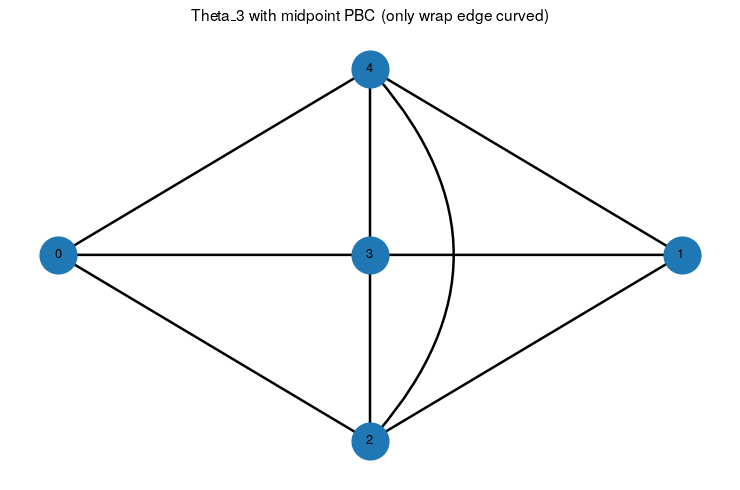

-Y**5 - Y**4 - 7*Y**3 - 6*Y**2 - 16*Y - 10 - 16/Y - 6/Y**2 - 7/Y**3 - 1/Y**4 - 1/Y**5


In [54]:
 
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict


def theta_s_with_mid_connections_pbc(s: int):
    """
    Abstract Theta_s: two endpoints (0,1) connected by s parallel strands.
    Subdivide each strand with a midpoint vertex m_i, and connect midpoints with PBC:
        m_i -- m_{i+1}  (mod s)
    For s=2, this adds only one midpoint edge (avoids a duplicate parallel edge).
    Returns: (yam, G, pos)
    """
    if s < 1:
        raise ValueError("s must be >= 1")

    v0, v1 = 0, 1
    mids = list(range(2, 2 + s))  # 2..(s+1)

    # Dummy vertices: Yamada uses len(vertices) for vertex-node offsets
    vertices = [SimpleNamespace() for _ in range(2 + s)]
    crossings = []

    arcs = []
    arc_id = 0

    def add_arc(u, v):
        nonlocal arc_id
        arcs.append(SimpleNamespace(
            id=arc_id,
            start_id=u, start_type='v',
            end_id=v,   end_type='v',
        ))
        arc_id += 1

    # Subdivide each strand: v0 -- m_i -- v1
    for m in mids:
        add_arc(v0, m)
        add_arc(m, v1)

    # PBC midpoint connections: m_i -- m_{i+1 mod s}
    # Use a set to avoid duplicates (important for s=2).
    midpoint_pairs = set()
    if s >= 2:
        for i in range(s):
            u = mids[i]
            v = mids[(i + 1) % s]
            pair = (min(u, v), max(u, v))
            if pair not in midpoint_pairs:
                midpoint_pairs.add(pair)
                add_arc(u, v)

    yam = Yamada(vertices=vertices, crossings=crossings, arcs=arcs)

    # Build MultiGraph for plotting
    G = nx.MultiGraph()
    G.add_nodes_from([v0, v1] + mids)
    for a in arcs:
        G.add_edge(a.start_id, a.end_id)

    # Layout: endpoints left/right; midpoints vertically between them
    pos = {v0: (0.0, 0.0), v1: (4.0, 0.0)}
    if s == 1:
        pos[mids[0]] = (2.0, 0.0)
    else:
        y_vals = [-(s - 1) / 2 + i for i in range(s)]
        for m, y in zip(mids, y_vals):
            pos[m] = (2.0, float(y))

    return yam, G, pos


def plot_multigraph_pbc_curved(G, pos, pbc_pairs=None, pbc_rad=0.35, title=None):
    """
    Draw a MultiGraph where ONLY edges in `pbc_pairs` are curved.
    Everything else is drawn straight.

    pbc_pairs: set of unordered node pairs, e.g. {(2, s+1)} for your midpoint wrap edge.
    pbc_rad  : curvature for the PBC edge.
    """
    if pbc_pairs is None:
        pbc_pairs = set()

    plt.figure(figsize=(7.5, 5))

    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edges one-by-one so we can selectively curve only the PBC connection
    for u, v, k in G.edges(keys=True):
        pair = (u, v) if u <= v else (v, u)
        rad = pbc_rad if pair in pbc_pairs else 0.0

        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width=1.8,
            connectionstyle=f"arc3,rad={rad}",
        )

    if title:
        plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# -------- Example usage -------- 
s = 3

yam, G, pos = theta_s_with_mid_connections_pbc(s)
Y_theta_pbc=yam.compute(A, normalize=False, n_jobs=-1)
print("Yamada (normalized):", yam.compute(A, normalize=True, n_jobs=-1))
print("Yamada (unnormalized):",Y_theta_pbc)
pbc_pairs = set()
pbc_pairs.add((2, s + 1))   # (m0, m_{s-1})

plot_multigraph_pbc_curved(G, pos, pbc_pairs=pbc_pairs, pbc_rad=0.45,
                           title=f"Theta_{s} with midpoint PBC (only wrap edge curved)")
print(sp.simplify(Y_theta3-Y_theta_pbc))

# Experiment 10 -  LiOsO3

In [74]:
import sympy as sp

# Real momenta (so conjugation behaves as expected)
qx, qy, qz = sp.symbols("q_x q_y q_z", real=True)
I = sp.I

# --- 2×2 Pauli matrices ---
s0 = sp.eye(2)
sx = sp.Matrix([[0, 1],[1, 0]])
sy = sp.Matrix([[0, -I],[I, 0]])
sz = sp.Matrix([[1, 0],[0, -1]])

t0 = sp.eye(2)
tx = sp.Matrix([[0, 1],[1, 0]])
ty = sp.Matrix([[0, -I],[I, 0]])
tz = sp.Matrix([[1, 0],[0, -1]])

def kron(A, B):
    return sp.kronecker_product(A, B)

# --- γ-matrices exactly as defined in the paper ---
# γ1 = τ3 s1, γ2 = τ3 s2, γ3 = τ1 s0, γ4 = τ2 s0, γ5 = τ3 s3
g1 = kron(tz, sx)
g2 = kron(tz, sy)
g3 = kron(tx, s0)
g4 = kron(ty, s0)
g5 = kron(tz, sz)

# Convenience: τ1 s2 term used in Eq. (9) and Eq. (10)
tau1_s2 = kron(tx, sy)

def Hcubic_T(qx, qy, qz, *, a1, a2, a3, b1, b2, b3, c1, c2, c3, c4):
    """
    Eq. (7) in the paper: cubic Dirac k·p model at T.
    Returns a 4×4 SymPy Matrix.
    """
    qp = qx + I*qy          # q_+
    qm = qx - I*qy          # q_-
    qpq = qp*qm             # = qx^2 + qy^2 for real qx,qy

    # Scalars multiplying the spin Pauli matrices inside h11/h12
    A = c1*(qp**3 + qm**3) + b1*(qpq*qz) + a1*qz
    B = c3*(qp**3 + qm**3) + b2*(qpq*qz) + a2*qz
    C = c4*(qp**3 + qm**3) + b3*(qpq*qz) + a3*qz

    # 2×2 blocks (spin space) as written in the paper
    h11 = A*sx + (I*c2*(qp**3 - qm**3))*sy + B*sz
    h12 = C*s0

    # Assemble 4×4 block matrix: [[h11, h12], [h12†, -h11]]
    top = sp.Matrix.hstack(h11, h12)
    bot = sp.Matrix.hstack(h12.H, -h11)
    return sp.simplify(sp.Matrix.vstack(top, bot))

def HCNR_T(qx, qy, qz, *, delta, **coeffs):
    """
    Eq. (9): crossed-nodal-ring minimal model at T in FE phase:
    H_T^CNR(q) = H_T^cubic(q) + δ τ1 s2
    """
    return sp.simplify(Hcubic_T(qx, qy, qz, **coeffs) + delta*tau1_s2)

def HL_L(qx, qy, qz, *, bx1, bz1, bx3, bz3, bx5, bz5, by):
    """
    Eq. (8): linear Dirac k·p model at L:
    H_L(q) = Σ_{i=1,3,5} (βx,i qx + βz,i qz) γ_i + βy qy γ2
    """
    return sp.simplify(
        (bx1*qx + bz1*qz)*g1 +
        (bx3*qx + bz3*qz)*g3 +
        (bx5*qx + bz5*qz)*g5 +
        (by*qy)*g2
    )

def HNR_L(qx, qy, qz, *, delta_p, **betas):
    """
    Eq. (10): nodal-ring model around L in FE phase:
    H_L^NR(q) = H_L(q) + δ' τ1 s2
    """
    return sp.simplify(HL_L(qx, qy, qz, **betas) + delta_p*tau1_s2) 


coeffs_T = dict(a1=0.2, a2=0.1, a3=0.15, b1=0.3, b2=0.25, b3=0.2, c1=2.0, c2=0.1, c3=0.8, c4=0.9)
H_T_cubic = Hcubic_T(qx, qy, qz, **coeffs_T)
H_T_CNR   = HCNR_T(qx, qy, qz, delta=0.3, **coeffs_T)

betas_L = dict(bx1=1.0, bz1=0.6, bx3=0.9, bz3=0.7, bx5=1.1, bz5=0.5, by=1.0)
H_L_lin = HL_L(qx, qy, qz, **betas_L)
H_L_NR  = HNR_L(qx, qy, qz, delta_p=0.15, **betas_L)


In [75]:
selected_panel="a"
out_folder = f"./Experiment10/{selected_panel}"
selected_band = "01"
selected_snap = "1"
Text="Topological Transitions For Experiment"
print(Text)

params_a = dict(BASE); params_a.update(PANELS[selected_panel])
 
  
x=np.pi
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 200
gap_tol =0.01# like tol0 in your script :contentReference[oaicite:6]{index=6}

 
 
H_T_FE_k = sp.simplify(H_T_CNR.subs({qx: kx, qy: ky, qz: kz}))  # q = k (center at T)

xT = 0.4  # small k·p window (tune 0.2–0.8)
span_T = ((-xT, xT), (-xT, xT), (-xT, xT))

ske = NodalSkeletonMultiBand(
    H_T_FE_k,
    k_symbols=(kx, ky, kz),
    span=span_T,
    dimension=200,
    band_pair=(2, 3),
    gap_tol=gap_tol,
)





# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1600, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="red",
    surf_opacity=0.8,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
 
        #backface_params=dict(color="red"),   
    ),
)

# Camera
pl.camera.elevation = -15
pl.camera.azimuth = 90

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.1 if i else 0.1,
    tube_radius=0.05,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1600, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = -15
pl_skel.camera.azimuth = 90

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 4 - Panel B:{0.35}
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: s

# Experiment 7 theory- (a) Ti3Al, (b) YH3 and (c) Co2MnGa

# Panel A

In [63]:
import sympy as sp

kx, ky, kz = sp.symbols("k_x k_y k_z", real=True)

def H_Ti3Al_sympy(params=None) -> sp.Matrix:
    # Defaults from Eq. (S7)
    p = dict(A1=-9.66, A2=11.37, B1=36.22, B2=-25.71, M1=0.12, M2=-0.52, C=22.34)
    if params: p.update(params)

    k2xy = kx**2 + ky**2
    h1 = p["A1"]*k2xy + p["B1"]*(kz**2) + p["M1"]
    h2 = p["A2"]*k2xy + p["B2"]*(kz**2) + p["M2"]
    h  = 2*p["C"]*kz

    eps = sp.Rational(1,2)*(h1 + h2 + sp.sqrt((h1 - h2)**2 + h**2))
    return sp.Matrix([[ eps, 0],
                      [ 0, -eps]])


In [73]:
selected_panel="a"
out_folder = f"./Experiment7/{selected_panel}"
selected_band = "01"
selected_snap = "arbitrary"
Text="Topological Transitions For Experiment 7 - Panel A:1 "
print(Text) 
H_a = H_Ti3Al_sympy()

  
x=np.pi
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 200
gap_tol =0.57# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=True,
    small_edge_limit=np.pi*0.1,  # k-space units
)

 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1700, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="red",
    surf_opacity=0.8,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
 
       #  backface_params=dict(color="red"),  # Enable for only for inner gap parts 
    ),
)

# Camera
pl.camera.elevation = 0
pl.camera.azimuth = 100

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.02 if i else 0.1,
    tube_radius=0.01,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1800, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = 0
pl_skel.camera.azimuth = 100

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 7 - Panel A:1 
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: synta

ValueError: The skeleton image is empty. Try increasing gap_tol, checking band_pair, or enlarging the k-span.

# Panel B

In [12]:
import sympy as sp

def H_YH3_sympy(params=None) -> sp.Matrix:
    p = dict(m1=2.99, a1=2.0, r1=1.032, s1=1.032, t1=1.032, n1=3,
             m2=2.96, m3=2.96, a2=4.0, a3=4.0)
    if params: p.update(params)

    g1, g2, g3 = sp.sin(kz), sp.sin(kx), sp.sin(ky)

    h1 = p["a1"]*(p["r1"]*sp.cos(kx)**p["n1"] +
                  p["s1"]*sp.cos(ky)**p["n1"] +
                  p["t1"]*sp.cos(kz)**p["n1"] - p["m1"])
    h2 = p["a2"]*(sp.cos(kx) + sp.cos(ky) + sp.cos(kz) - p["m2"])
    h3 = p["a3"]*(sp.cos(kx) + sp.cos(ky) + sp.cos(kz) - p["m3"])

    eps = sp.sqrt((g1**2 + h1**2)*(g2**2 + h2**2)*(g3**2 + h3**2))
    return sp.Matrix([[ eps, 0],
                      [ 0, -eps]])


In [13]:
selected_panel="b"
out_folder = f"./Experiment7/{selected_panel}"
selected_band = "01"
selected_snap = "3"
Text="Topological Transitions For Experiment 7 - Panel B: 0.006,0.02 "
print(Text) 
H_a = H_YH3_sympy()

  
x=np.pi
span = ((-x, x), (-x, x), (-x, x))  # same idea as your bounds
dimension = 200
gap_tol =0.005# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=False,
    small_edge_limit=np.pi*0.1,  # k-space units
)

 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1700, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="blue",
    surf_opacity=0.4,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
        backface_params=dict(color="red"),   
    ),
)

# Camera
pl.camera.elevation = -15
pl.camera.azimuth = 120

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.05 if i else 0.1,
    tube_radius=0.02,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1800, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = -15
pl_skel.camera.azimuth = 120

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 7 - Panel B: 0.006,0.02 
MuPDF error: syntax error: cannot find ExtGState resource 'GS10'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS20'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS30'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS40'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS50'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS60'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS70'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF error: syntax error: cannot find ExtGState resource 'GS80'

MuPDF error: syntax error: unknown keyword: 'ca'

MuPDF er

In [33]:
import knotted_graph as kg
A = sp.symbols('Y') 

G = ske.skeleton_graph() # Ensure the skeleton graph is computed and cached
print("Is the skeleton graph trivalent?", ske.is_graph_trivalent)
pd = kg.PDCode(skeleton_graph=G)

pd_code = pd.compute( 
    rotation_angles=( 120.5, 120.4, 180.),
    # rotation_order='ZYX',
)
pd_code


Is the skeleton graph trivalent? False


'V[0,2,3,1];V[4,6,1,5];V[7,8,0,4];V[9,2,10,7];V[3,11,9,5];V[8,10,11,6]'

In [34]:
print(pd.compute_yamada(A, normalize=True))

-Y**14 - 2*Y**13 - 13*Y**12 - 18*Y**11 - 60*Y**10 - 64*Y**9 - 125*Y**8 - 97*Y**7 - 125*Y**6 - 64*Y**5 - 60*Y**4 - 18*Y**3 - 13*Y**2 - 2*Y - 1


# Panel C

In [9]:
import sympy as sp

def H_Co2MnGa_TB6_sympy(params=None) -> sp.Matrix:
    # Defaults from Eq. (S11)
    p = dict(t1=-0.31, t2=-0.018, t3=-0.01, t4=0.2, t5=-0.02, t6=0.04,
             t7=0.28, t8=-0.34, eps_d=-0.6, eps_p=0.6)
    if params: p.update(params)

    cx2, cy2, cz2 = sp.cos(kx/2), sp.cos(ky/2), sp.cos(kz/2)
    sx2, sy2, sz2 = sp.sin(kx/2), sp.sin(ky/2), sp.sin(kz/2)

    # d-block (S11a-c)
    xi_d1 = 4*p["t1"]*cx2*cz2 + 2*p["t2"]*(sp.cos(kx)+sp.cos(kz)) + 2*p["t3"]*sp.cos(ky) + p["eps_d"]
    xi_d2 = 4*p["t1"]*cy2*cz2 + 2*p["t2"]*(sp.cos(ky)+sp.cos(kz)) + 2*p["t3"]*sp.cos(kx) + p["eps_d"]
    xi_d3 = 4*p["t1"]*cx2*cy2 + 2*p["t2"]*(sp.cos(kx)+sp.cos(ky)) + 2*p["t3"]*sp.cos(kz) + p["eps_d"]

    # p-block (S11d-f)
    xi_p1 = 4*p["t4"]*cy2*cz2 + 2*p["t5"]*(sp.cos(ky)+sp.cos(kz)) + 2*p["t6"]*sp.cos(kx) + p["eps_p"]
    xi_p2 = 4*p["t4"]*cx2*cz2 + 2*p["t5"]*(sp.cos(kx)+sp.cos(kz)) + 2*p["t6"]*sp.cos(ky) + p["eps_p"]
    xi_p3 = 4*p["t4"]*cx2*cy2 + 2*p["t5"]*(sp.cos(kx)+sp.cos(ky)) + 2*p["t6"]*sp.cos(kz) + p["eps_p"]

    xi_p12 = -4*p["t7"]*sx2*sy2
    xi_p23 = -4*p["t7"]*sy2*sz2
    xi_p31 = -4*p["t7"]*sx2*sz2

    # d-p couplings (S11j-l)
    xi_dp11 = 2*p["t8"]*sz2
    xi_dp22 = 2*p["t8"]*sz2
    xi_dp13 = 2*p["t8"]*sx2
    xi_dp32 = 2*p["t8"]*sx2
    xi_dp23 = 2*p["t8"]*sy2
    xi_dp31 = 2*p["t8"]*sy2

    # Matrix pattern from Eq. (S10)
    return sp.Matrix([
        [xi_d1,   0,      0,      xi_dp11, 0,       xi_dp13],
        [0,       xi_d2,  0,      0,       xi_dp22, xi_dp23],
        [0,       0,      xi_d3,  xi_dp31, xi_dp32, 0      ],
        [xi_dp11, 0,      xi_dp31, xi_p1,  xi_p12,  xi_p31 ],
        [0,       xi_dp22, xi_dp32, xi_p12, xi_p2,  xi_p23 ],
        [xi_dp13, xi_dp23, 0,      xi_p31, xi_p23,  xi_p3  ],
    ])


In [10]:
selected_panel="d"
out_folder = f"./Experiment7/{selected_panel}"
selected_band = "01"
selected_snap = "arbitrary"
Text="Topological Transitions For Experiment 7 - Panel C:0.25 ,1.15"
print(Text) 
H_a = H_Co2MnGa_TB6_sympy()
Text2="Yamada 1 unitcell results 0.15: -Y**4 - 3*Y**3 - 5*Y**2 - 4*Y - 2" \
"0.5: -Y**10 + 2*Y**9 - 7*Y**8 + 5*Y**7 - 14*Y**6 + 6*Y**5 - 14*Y**4 + 5*Y**3 - 7*Y**2 + 2*Y - 1"
  
x=np.pi*2.1
#span2 = ((-x, x), (-x, x), (-x, x))   
span = ((0, x), (0, x), (0, x))   
dimension = 200
gap_tol =10# like tol0 in your script :contentReference[oaicite:6]{index=6}

# Gap between bands 1 and 2 (Δ12)
ske_01 = NodalSkeletonMultiBand(
    H_a,
    k_symbols=(kx, ky, kz),
    span=span,
    dimension=dimension,
    band_pair=(0, 1),
    gap_tol=gap_tol,
    force_small_edge_contraction=True,
    small_edge_limit=np.pi*0.1,  # k-space units
)

 
ske = ske_01  




# -------------------------
# 1) Exceptional surface
# -------------------------
pl = pv.Plotter(window_size=(1700, 1400))
pl.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
ske.plot_exceptional_surface(
    pl,
    surf_color="red",
    surf_opacity=0.8,
    surf_kwargs=dict(
        smooth_shading=True,
        specular=0.10,
        diffuse=0.80,
        ambient=0.30,
        show_edges=False,
        edge_color=(0.55, 0.55, 0.55),
        line_width=0.8,
        #backface_params=dict(color="red"),   
    ),
)

# Camera
pl.camera.elevation = -10
pl.camera.azimuth = 160

raw_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw.pdf"
cropped_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped.pdf"
final_pdf = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final.pdf"


save_plotter_pdf(
    pl,
    raw_pdf,
    cropped_pdf,
    folder=out_folder,
    crop_margin=0.1,
    compress=True,
    final_pdf=final_pdf,
    target_mb=0.1,
    keep_final=True,
    show=False,
)


pl.close()


# -------------------------
# 2) Skeleton (separate file)
# -------------------------
# Choose i = 0 or 1 depending on the styling you want
i = 1

pl_skel = ske.plot_skeleton_graph(
    node_radius=0.3 if i else 0.1,
    tube_radius=0.05,
    node_color="#A60628" if i else "#15B448",
    edge_color="#348ABD" if i else "#15B448",
)

# Make skeleton export match the surface export as closely as possible
try:
    pl_skel.window_size = (1800, 1400)
except Exception:
    pass

try:
    pl_skel.enable_depth_peeling(number_of_peels=300, occlusion_ratio=0.0)
except Exception:
    pass

pl_skel.camera.elevation = -10
pl_skel.camera.azimuth = 160

raw_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_raw_skeleton.pdf"
cropped_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_cropped_skeleton.pdf"
final_pdf_skel = f"./option_{selected_panel}_band_{selected_band}_{selected_snap}stsnap_final_skeleton.pdf"

save_plotter_pdf(
    pl_skel,
    raw_pdf_skel,
    cropped_pdf_skel,
    folder=out_folder,
    crop_margin=180,   # pixels is safer for skeleton axes
    compress=True,
    final_pdf=final_pdf_skel,
    target_mb=0.1,
    keep_final=True,
    show=False,
)

pl_skel.close()


Topological Transitions For Experiment 7 - Panel C:0.25 ,1.15


NotAllTrianglesError: Input mesh for decimation must be all triangles.

In [58]:
import knotted_graph as kg
A = sp.symbols('Y') 

G = ske.skeleton_graph() # Ensure the skeleton graph is computed and cached
print("Is the skeleton graph trivalent?", ske.is_graph_trivalent)
pd = kg.PDCode(skeleton_graph=G)

pd_code = pd.compute( 
    rotation_angles=( 60, 60, 130.),
    # rotation_order='ZYX',
)
pd_code


Is the skeleton graph trivalent? True


'V[0,4,2];V[6,3,7];V[7,8,10];V[12,14,6];V[13,1,16];V[5,17,9];V[16,17,18];V[15,19,11];X[8,11,9,10];X[1,13,0,12];X[2,15,3,14];X[4,18,5,19]'

In [59]:
print(pd.compute_yamada(A, normalize=True))

-Y**10 + 2*Y**9 - 7*Y**8 + 5*Y**7 - 14*Y**6 + 6*Y**5 - 14*Y**4 + 5*Y**3 - 7*Y**2 + 2*Y - 1


Connected components: 1


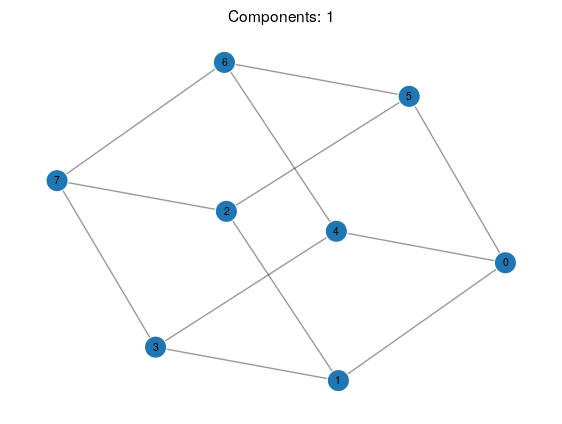

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
 
G=ske.skeleton_graph() 
# --- 1) Count components ---
if G.is_directed():
    n_weak = nx.number_weakly_connected_components(G)
    n_strong = nx.number_strongly_connected_components(G)
    print("Weakly connected components:", n_weak)
    print("Strongly connected components:", n_strong)
else:
    n_cc = nx.number_connected_components(G)
    print("Connected components:", n_cc)

# --- 2) Get the node-sets for components (so we can color them) ---
if G.is_directed():
    comps = list(nx.weakly_connected_components(G))   # or nx.strongly_connected_components(G)
else:
    comps = list(nx.connected_components(G))

# Optional: sort components by size (largest first)
comps = sorted(comps, key=len, reverse=True)

# Map each node -> component index
comp_id = {}
for i, nodes in enumerate(comps):
    for v in nodes:
        comp_id[v] = i

# --- 3) Plot: color nodes by component ---
pos = nx.spring_layout(G, seed=0)  # deterministic layout
node_colors = [comp_id[v] for v in G.nodes()]

plt.figure(figsize=(7, 5))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=200)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis("off")
plt.title(f"Components: {len(comps)}")
plt.show()


### Note: Can solve via only a portion by exploiting symmetry not -pi to pi but 0 to pi 8 fold symm

# Merging Part
## Merging Experiment 7

KeyboardInterrupt: 

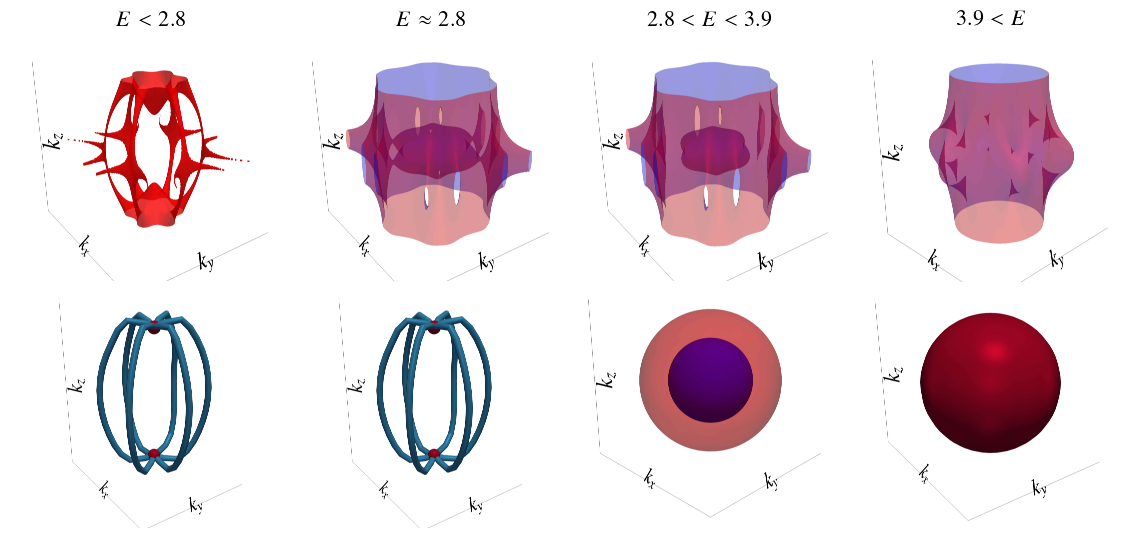

In [7]:
import re
import io
import os
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image, ImageChops

# -----------------------
# CONFIG
# -----------------------
Text = "Topological Transitions For Experiment 4 - Panel A: {2.8, 3.9}"

base_dir = Path("./Experiment4")
panels = ["a"]                 # each folder will produce ONE output figure
SAVE_DPI = 300

# If True: trims uniform borders inside each image (useful if exports have white margins)
TRIM_BORDERS = False

# Supported extensions (first match wins if duplicates exist)
EXT_PRIORITY = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".pdf"]

# Column boxing style (outer border + vertical separators)
BOX_LW = 2.5                   # line width (boldness)
BOX_PAD = 0.0                  # outward padding around grid in figure coords (0 => touching)

# Tight adjacency between axes
WSPACE = 0.0                   # must be 0 for touching columns
HSPACE = 0

# Margins (leave room for titles/suptitle while keeping columns touching)
LEFT = 0.2
RIGHT = 1
BOTTOM = 0.1
TOP = 0.8                 # reduce if you want less top whitespace

# Column titles (LaTeX via matplotlib mathtext)
COL_TITLE_FONTSIZE = 16
COL_TITLE_PAD = 10

COL_TITLES = {
    "col1": r"$E < 2.8$",
    "col2": r"$E \approx 2.8$",
    "col3": r"$2.8 < E < 3.9$",
    "col4": r"$3.9<E$",
}
FALLBACK_AS_LATEX = True
# Subpanel labels (top-left of each COLUMN)
SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 18
SUBPANEL_PAD_X = 0.0035
SUBPANEL_PAD_Y = 0.002
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # or None
SUBPANEL_FONTWEIGHT = "bold"
# -----------------------
# OPTIONAL PDF COMPRESSION
# -----------------------
COMPRESS_FINAL_PDF = True

# Option A: fixed rasterization settings
FIXED_DPI = None               # e.g., 200 to force fixed rasterization; None => use target-MB loop
FIXED_QUALITY = 80             # JPEG quality 1–95 (higher = better quality, larger)

# Option B: aim for target size (MB) by lowering DPI/quality
TARGET_MB = 0.5
START_DPI = 200
START_QUALITY = 85
MIN_DPI = 300
MIN_QUALITY = 300
DPI_DECAY = 0.85               # multiply dpi by this each iteration
QUALITY_DECAY = 0.92           # multiply quality by this each iteration

# -----------------------
# HELPERS
# -----------------------
def trim_border(im: Image.Image, bg_color=None) -> Image.Image:
    if bg_color is None:
        bg_color = im.getpixel((0, 0))
    bg = Image.new(im.mode, im.size, bg_color)
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    return im.crop(bbox) if bbox else im

def read_image(path: Path) -> Image.Image:
    suffix = path.suffix.lower()

    if suffix == ".pdf":
        try:
            import fitz  # PyMuPDF
        except ImportError as e:
            raise ImportError(
                "PDF input detected, but PyMuPDF is not installed. "
                "Install with: pip install pymupdf"
            ) from e
        doc = fitz.open(str(path))
        page = doc.load_page(0)
        pix = page.get_pixmap(dpi=300, alpha=False)
        im = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
        doc.close()
    else:
        im = Image.open(path).convert("RGB")

    if TRIM_BORDERS:
        im = trim_border(im)

    return im

def natural_sort_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

def pick_file(panel_dir: Path, stem: str) -> Path | None:
    for ext in EXT_PRIORITY:
        p = panel_dir / f"{stem}{ext}"
        if p.exists():
            return p
    return None

def get_col_title(col_key: str) -> str:
    if col_key in COL_TITLES:
        return COL_TITLES[col_key]
    return rf"${col_key}$" if FALLBACK_AS_LATEX else col_key

# --- PDF compression utilities (rasterize -> image-only PDF) ---
def rasterize_pdf_to_small_pdf(in_pdf: str, out_pdf: str, dpi: int = 200, jpeg_quality: int = 80) -> None:
    import fitz  # PyMuPDF

    src = fitz.open(in_pdf)
    dst = fitz.open()

    for page in src:
        pix = page.get_pixmap(dpi=dpi, alpha=False)
        img = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)

        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=int(jpeg_quality), optimize=True)
        img_bytes = buf.getvalue()

        # Page size in points (72 pt/in)
        w_pt = pix.width / dpi * 72.0
        h_pt = pix.height / dpi * 72.0

        new_page = dst.new_page(width=w_pt, height=h_pt)
        new_page.insert_image(fitz.Rect(0, 0, w_pt, h_pt), stream=img_bytes)

    dst.save(out_pdf, deflate=True)
    dst.close()
    src.close()

def compress_raster_pdf_to_target_mb(
    in_pdf: str,
    out_pdf: str,
    target_mb: float,
    start_dpi: int = 240,
    start_quality: int = 85,
    min_dpi: int = 96,
    min_quality: int = 45,
    dpi_decay: float = 0.85,
    quality_decay: float = 0.92,
) -> tuple[float, int, int]:
    dpi = int(start_dpi)
    q = int(start_quality)

    while True:
        fd, tmp_path = tempfile.mkstemp(suffix=".pdf")
        os.close(fd)

        rasterize_pdf_to_small_pdf(in_pdf, tmp_path, dpi=dpi, jpeg_quality=q)
        size_mb = os.path.getsize(tmp_path) / (1024 * 1024)

        if size_mb <= target_mb or (dpi <= min_dpi and q <= min_quality):
            Path(tmp_path).replace(out_pdf)
            return size_mb, dpi, q

        os.remove(tmp_path)
        dpi = max(min_dpi, int(dpi * dpi_decay))
        q = max(min_quality, int(q * quality_decay))

# -----------------------
# MAIN: build one 2xN per panel
# -----------------------
pattern = re.compile(r"^(?P<col>.+)_row(?P<row>[12])_cropped$", re.IGNORECASE)

for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5 * ncols)
    fig_h = 7

    # IMPORTANT: no constrained_layout => we can enforce wspace=0 for touching columns
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    # Column titles (top row)
    for j, c in enumerate(cols):
        axes[0][j].set_title(get_col_title(c), fontsize=COL_TITLE_FONTSIZE, pad=COL_TITLE_PAD)
 
    # Finalize layout before drawing figure-level borders
    fig.canvas.draw()
    # ---- Add (a)(b)(c)... at top-left of each column (spanning both rows) ----
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [f"({chr(97+i)})" for i in range(start, ncols)]  # (a),(b),...

    for j in range(ncols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left + SUBPANEL_PAD_X,
            y_top - SUBPANEL_PAD_Y,
            labels[j],
            transform=fig.transFigure,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            fontweight=SUBPANEL_FONTWEIGHT,
            bbox=SUBPANEL_BBOX,
            zorder=1100,  # above your BOX_LW lines (zorder=1000)
        )

    # ---- Draw touching column boxes: outer border + vertical separators ----
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD+0.01

    # Outer rectangle
    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators between columns (single stroke, no double-thickness)
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)  # right edge of column j

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


In [32]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================

# 1) Override only what changes for panel b
panels = ["b"]

COL_TITLES = {
    "col1": r"$E < 0.35$",
    "col2": r"$0.35 < E < 3.95$",
    "col3": r"$3.95<E$",
}

# --- NEW: figure-level title + subpanel label controls ---
TITLE_Y_PAD = 0.01  # move titles up/down (figure coords)

SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_PAD_X = 0.005
SUBPANEL_PAD_Y = 0.007
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5 * ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # --- NEW: centered column titles (figure coords) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- NEW: bold LaTeX (a)(b)(c)... at top-left of each column ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

    for j in range(ncols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left + SUBPANEL_PAD_X,
            y_top - SUBPANEL_PAD_Y,
            labels[j],
            transform=fig.transFigure,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # Outer border
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


[b] Saved:
  - Experiment4/b/combined_b_2x3.png
  - Experiment4/b/combined_b_2x3.pdf
[b] Compressed (target): Experiment4/b/combined_b_2x3_final.pdf (0.13 MB) using dpi=200, q=85


In [40]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================

from matplotlib.transforms import ScaledTranslation  # <-- NEW (needed for point-based inset)

# 1) Override only what changes for panel b
panels = ["c"]

Text="Topological Transitions For Experiment 4 - Panel C:3.65 ,4.2"
COL_TITLES = {
    "col1": r"$E < 3.65$",
    "col2": r"$3.65 < E < 4.2$",
    "col3": r"$4.2<E$",
}

# --- NEW: figure-level title + subpanel label controls ---
TITLE_Y_PAD = 0.01  # move titles up/down (figure coords)

SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_PAD_X = 0.0005
SUBPANEL_PAD_Y = 0.009
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable

# --- NEW: fixed inset from the box top-left (in points) ---
SUBPANEL_INSET_X_PT = 6   # move right
SUBPANEL_INSET_Y_PT = 6   # move down

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5 * ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # --- NEW: centered column titles (figure coords) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- UPDATED: bold LaTeX (a)(b)(c)... anchored to box top-left, inset by fixed points ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

 
    for j in range(ncols):
        if j==1:
            offset_tf = fig.transFigure + ScaledTranslation(
            SUBPANEL_INSET_X_PT / 164.0,     # points -> inches
            -SUBPANEL_INSET_Y_PT / 72.0,    # down is negative
            fig.dpi_scale_trans)
        else:
            offset_tf = fig.transFigure + ScaledTranslation(
            SUBPANEL_INSET_X_PT / 72.0,     # points -> inches
            -SUBPANEL_INSET_Y_PT / 72.0,    # down is negative
            fig.dpi_scale_trans)

        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left,
            y_top,
            labels[j],
            transform=offset_tf,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # Outer border
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


[c] Saved:
  - Experiment4/c/combined_c_2x3.png
  - Experiment4/c/combined_c_2x3.pdf
[c] Compressed (target): Experiment4/c/combined_c_2x3_final.pdf (0.14 MB) using dpi=200, q=85


## Merging Experiment 7

In [2]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================
from matplotlib.transforms import ScaledTranslation  # NEW: for point-based inset of (a)(b)...

base_dir = Path("./Experiment7")

# 1) Override only what changes for panel b
panels = ["a"]

Text="Topological Transitions For Experiment 7 - Panel A:1 "
COL_TITLES = {
    "col1": r"$E < 1$",
    "col2": r"$1 < E$",
}

# --- NEW: figure-level title + subpanel label controls ---
TITLE_Y_PAD = 0.01  # move titles up/down (figure coords)

SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable

# fixed inset from the box top-left (in points)
SUBPANEL_INSET_X_PT = 6   # move right
SUBPANEL_INSET_Y_PT = 6   # move down

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5 * ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # --- UPDATED: centered column titles (figure coords) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- UPDATED: bold LaTeX (a)(b)(c)... anchored to box top-left, inset by fixed points ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

    offset_tf = fig.transFigure + ScaledTranslation(
        SUBPANEL_INSET_X_PT / 72.0,     # points -> inches
        -SUBPANEL_INSET_Y_PT / 72.0,    # down is negative
        fig.dpi_scale_trans
    )

    for j in range(ncols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left,
            y_top,
            labels[j],
            transform=offset_tf,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # Outer border
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


NameError: name 'Path' is not defined

In [43]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================
from matplotlib.transforms import ScaledTranslation  # NEW: fixed point-based inset

base_dir = Path("./Experiment7")

# 1) Override only what changes for panel b
panels = ["b"]

Text="Topological Transitions For Experiment 7 - Panel B: 0.006,0.02 "
COL_TITLES = {
    "col1": r"$E < 0.006$",
    "col2": r"$0.006 < E < 0.2$",
    "col3": r"$0.2 < E$"
}

# --- NEW: centered title control (figure coords) ---
TITLE_Y_PAD = 0.01  # move titles up/down

# --- NEW: bold LaTeX subpanel labels + fixed inset from column-box top-left ---
SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable
SUBPANEL_INSET_X_PT = 6   # move right (points)
SUBPANEL_INSET_Y_PT = 6   # move down  (points)

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5 * ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    fig.canvas.draw()  # keep this BEFORE computing positions

    # --- UPDATED: centered column titles (no per-column TITLE_PAD hacks) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- NEW: subpanel labels anchored to column-box top-left, inset by fixed points ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

    offset_tf = fig.transFigure + ScaledTranslation(
        SUBPANEL_INSET_X_PT / 72.0,
        -SUBPANEL_INSET_Y_PT / 72.0,
        fig.dpi_scale_trans
    )

    for j in range(ncols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top  = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left,
            y_top,
            labels[j],
            transform=offset_tf,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # Outer border
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


[b] Saved:
  - Experiment7/b/combined_b_2x3.png
  - Experiment7/b/combined_b_2x3.pdf
[b] Compressed (target): Experiment7/b/combined_b_2x3_final.pdf (0.12 MB) using dpi=200, q=85


In [65]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================
from matplotlib.transforms import ScaledTranslation  # NEW: fixed point-based inset

base_dir = Path("./Experiment7")
LEFT = 0.3

# 1) Override only what changes for panel b
panels = ["c"]

Text="Topological Transitions For Experiment 7 - Panel C:0.25 ,1.15"
COL_TITLES = {
    "col1": r"$E < 0.25$",
    "col2": r"$0.25 < E < 1.15$",
    "col3": r"$1.15 < E$"
}

# --- NEW: centered title control (figure coords) ---
TITLE_Y_PAD = 0.01  # move titles up/down

# --- NEW: bold LaTeX subpanel labels + fixed inset from column-box top-left ---
SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable
SUBPANEL_INSET_X_PT = 6   # move right (points)
SUBPANEL_INSET_Y_PT = 6   # move down  (points)

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5* ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)

    fig.canvas.draw()  # IMPORTANT: draw before using get_position()

    # --- UPDATED: centered column titles (figure coords) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- NEW: subpanel labels anchored to column-box top-left, inset by fixed points ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

    offset_tf = fig.transFigure + ScaledTranslation(
        SUBPANEL_INSET_X_PT / 72.0,
        -SUBPANEL_INSET_Y_PT / 72.0,
        fig.dpi_scale_trans
    )

    for j in range(ncols):
        bb_top = axes[0][j].get_position()
        bb_bot = axes[1][j].get_position()

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top  = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left,
            y_top,
            labels[j],
            transform=offset_tf,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # Outer border
    bbs = [axes[r][j].get_position() for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position()
        bb_col_bot = axes[1][j].get_position()
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


[c] Saved:
  - Experiment7/c/combined_c_2x3.png
  - Experiment7/c/combined_c_2x3.pdf
[c] Compressed (target): Experiment7/c/combined_c_2x3_final.pdf (0.20 MB) using dpi=200, q=85


In [21]:
# =========================
# PANEL B ONLY (NEW BLOCK)
# =========================
from matplotlib.transforms import ScaledTranslation  # NEW: fixed point-based inset

base_dir = Path("./Experiment7")
LEFT = 0.3

# --- NEW: add gap between panels (override spacing just for this block) ---
WSPACE = 0.08
HSPACE = 0.10

# 1) Override only what changes for panel b
panels = ["d"]

Text="Topological Transitions For Experiment 7 - Panel C:0.25 ,1.15"
COL_TITLES = {
    "col1": r"$E < 0.25$",
    "col2": r"$0.25 < E < 1.15$",
    "col3": r"$1.15 < E$"
}

# --- NEW: centered title control (figure coords) ---
TITLE_Y_PAD = 0.01  # move titles up/down

# --- NEW: bold LaTeX subpanel labels + fixed inset from column-box top-left ---
SUBPANEL_LABELS = [r"$\mathbf{(a)}$", r"$\mathbf{(b)}$", r"$\mathbf{(c)}$", r"$\mathbf{(d)}$"]
SUBPANEL_FONTSIZE = 16
SUBPANEL_BBOX = dict(facecolor="white", edgecolor="none", alpha=1, pad=2.5)  # set to None to disable
SUBPANEL_INSET_X_PT = 6   # move right (points)
SUBPANEL_INSET_Y_PT = 6   # move down  (points)

# (Optional) if you want a suptitle and your main loop doesn't already add it:
# Text = "Topological Transitions For Experiment 4 - Panel B: {0.35, 3.95}"
pattern = re.compile(r"^(?P<col>col\d+)_row(?P<row>[12])_cropped$")

# 2) Re-run the same main loop (unchanged logic)
for panel in panels:
    panel_dir = base_dir / panel
    if not panel_dir.exists():
        print(f"Skipping missing folder: {panel_dir}")
        continue

    # Find all (col, row) pairs available
    entries = []
    for p in panel_dir.iterdir():
        if not p.is_file():
            continue
        if p.suffix.lower() not in EXT_PRIORITY:
            continue
        m = pattern.match(p.stem)
        if m:
            entries.append((m.group("col"), int(m.group("row"))))

    cols = sorted({c for c, _ in entries}, key=natural_sort_key)
    if not cols:
        print(f"No files matching '*_row1/2.*' found in {panel_dir}")
        continue

    ncols = len(cols)
    nrows = 2

    # Load images into grid[row-1][col_index]
    grid = [[None] * ncols for _ in range(nrows)]
    missing = []

    for j, c in enumerate(cols):
        for r in [1, 2]:
            stem = f"{c}_row{r}"
            f = pick_file(panel_dir, stem)
            if f is None:
                missing.append(str(panel_dir / f"{stem}.*"))
                continue
            grid[r - 1][j] = read_image(f)

    if missing:
        print(f"[{panel}] Missing expected files:")
        for m in missing:
            print("  -", m)

    # Figure size: scale with number of columns
    fig_w = max(8, 3.5* ncols)
    fig_h = 7

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_w, fig_h),
        constrained_layout=False,
        gridspec_kw={"wspace": WSPACE, "hspace": HSPACE},
    )
    fig.subplots_adjust(left=LEFT, right=RIGHT, bottom=BOTTOM, top=TOP, wspace=WSPACE, hspace=HSPACE)

    # Normalize axes shape when ncols==1
    if ncols == 1:
        axes = [[axes[0]], [axes[1]]]

    # Draw images
    for r in range(nrows):
        for j in range(ncols):
            ax = axes[r][j]
            ax.axis("off")
            im = grid[r][j]
            if im is None:
                ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=14)
            else:
                ax.imshow(im)


    fig.canvas.draw()  # IMPORTANT: draw before using get_position()

    # --- UPDATED: centered column titles (figure coords) ---
    for j, c in enumerate(cols):
        bb_top = axes[0][j].get_position(original=True)
        bb_bot = axes[1][j].get_position(original=True)

        x0_col = min(bb_top.x0, bb_bot.x0)
        x1_col = max(bb_top.x1, bb_bot.x1)
        y1_col = max(bb_top.y1, bb_bot.y1)

        x_center = 0.5 * (x0_col + x1_col)

        fig.text(
            x_center,
            y1_col + TITLE_Y_PAD,
            get_col_title(c),
            ha="center",
            va="bottom",
            fontsize=COL_TITLE_FONTSIZE,
            transform=fig.transFigure,
            zorder=1100,
        )

    # --- NEW: subpanel labels anchored to column-box top-left, inset by fixed points ---
    labels = list(SUBPANEL_LABELS) if SUBPANEL_LABELS else []
    if len(labels) < ncols:
        start = len(labels)
        labels += [rf"$\mathbf{{({chr(97+i)})}}$" for i in range(start, ncols)]

    offset_tf = fig.transFigure + ScaledTranslation(
        SUBPANEL_INSET_X_PT / 72.0,
        -SUBPANEL_INSET_Y_PT / 72.0,
        fig.dpi_scale_trans
    )

    for j in range(ncols):
        bb_top = axes[0][j].get_position(original=True)
        bb_bot = axes[1][j].get_position(original=True)

        x_left = min(bb_top.x0, bb_bot.x0)
        y_top  = max(bb_top.y1, bb_bot.y1)

        fig.text(
            x_left,
            y_top,
            labels[j],
            transform=offset_tf,
            ha="left",
            va="top",
            fontsize=SUBPANEL_FONTSIZE,
            bbox=SUBPANEL_BBOX,
            zorder=1100,
        )

    # If you want a suptitle and you set Text above, uncomment this:
    # if Text:
    #     fig.suptitle(Text, fontsize=16, y=0.97)

    fig.canvas.draw()

    # Outer border
    bbs = [axes[r][j].get_position(original=True) for r in range(nrows) for j in range(ncols)]
    x0 = min(bb.x0 for bb in bbs) - BOX_PAD
    x1 = max(bb.x1 for bb in bbs) + BOX_PAD
    y0 = min(bb.y0 for bb in bbs) - BOX_PAD-0.005
    y1 = max(bb.y1 for bb in bbs) + BOX_PAD

    outer = patches.Rectangle(
        (x0, y0),
        x1 - x0,
        y1 - y0,
        transform=fig.transFigure,
        fill=False,
        linewidth=BOX_LW,
        edgecolor="black",
        zorder=1000,
    )
    fig.add_artist(outer)

    # Vertical separators
    for j in range(ncols - 1):
        bb_col_top = axes[0][j].get_position(original=True)
        bb_col_bot = axes[1][j].get_position(original=True)
        x_sep = max(bb_col_top.x1, bb_col_bot.x1)

        line = Line2D(
            [x_sep, x_sep],
            [y0, y1],
            transform=fig.transFigure,
            linewidth=BOX_LW,
            color="black",
            zorder=1000,
        )
        fig.add_artist(line)

    # Save outputs
    out_png = panel_dir / f"combined_{panel}_2x{ncols}.png"
    out_pdf = panel_dir / f"combined_{panel}_2x{ncols}.pdf"
    fig.savefig(out_png, dpi=SAVE_DPI, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=SAVE_DPI, bbox_inches="tight")
    plt.close(fig)

    print(f"[{panel}] Saved:\n  - {out_png}\n  - {out_pdf}")

    # Optional compression (creates an additional _final.pdf)
    if COMPRESS_FINAL_PDF:
        final_pdf = panel_dir / f"combined_{panel}_2x{ncols}_final.pdf"

        if FIXED_DPI is not None:
            rasterize_pdf_to_small_pdf(str(out_pdf), str(final_pdf), dpi=int(FIXED_DPI), jpeg_quality=int(FIXED_QUALITY))
            size_mb = final_pdf.stat().st_size / (1024 * 1024)
            print(f"[{panel}] Compressed (fixed): {final_pdf} ({size_mb:.2f} MB)")
        else:
            size_mb, used_dpi, used_q = compress_raster_pdf_to_target_mb(
                str(out_pdf),
                str(final_pdf),
                target_mb=TARGET_MB,
                start_dpi=START_DPI,
                start_quality=START_QUALITY,
                min_dpi=MIN_DPI,
                min_quality=MIN_QUALITY,
                dpi_decay=DPI_DECAY,
                quality_decay=QUALITY_DECAY,
            )
            print(f"[{panel}] Compressed (target): {final_pdf} ({size_mb:.2f} MB) using dpi={used_dpi}, q={used_q}")


[d] Saved:
  - Experiment7/d/combined_d_2x3.png
  - Experiment7/d/combined_d_2x3.pdf
[d] Compressed (target): Experiment7/d/combined_d_2x3_final.pdf (0.12 MB) using dpi=200, q=85


# Cropping Tool

In [11]:
# Crop PDFs to content (vector-preserving via CropBox) with independent margins
# Outputs <name>_cropped.pdf next to each input PDF.

from pathlib import Path

import fitz  # pip install pymupdf
from PIL import Image

# -----------------------
# CONFIG
# -----------------------
ROOT = Path("./Experiment7")
GLOB = "**/*.pdf"
OUT_SUFFIX = "_cropped"

RENDER_DPI = 120     # only for detecting content bbox
THRESH = 245         # 0..255, pixels darker than this are treated as content

# Independent margins in POINTS (72 pt = 1 inch)
MARGIN_LEFT_PT = 10
MARGIN_RIGHT_PT = 600
MARGIN_TOP_PT = 200
MARGIN_BOTTOM_PT = 400

SKIP_IF_HAS_SUFFIX = True
SKIP_STEMS = ("_cropped", "_final")


# -----------------------
# HELPERS
# -----------------------
def _content_bbox_from_pixmap(pix: fitz.Pixmap, thresh: int):
    """Return content bbox in pixel coords (x0,y0,x1,y1) or None if no content."""
    im = Image.frombytes("RGB", (pix.width, pix.height), pix.samples).convert("L")
    mask = im.point(lambda v: 255 if v < thresh else 0, mode="L")
    return mask.getbbox()

def crop_pdf_to_content(
    in_pdf: Path,
    out_pdf: Path,
    render_dpi: int,
    thresh: int,
    margin_left_pt: float,
    margin_right_pt: float,
    margin_top_pt: float,
    margin_bottom_pt: float,
) -> None:
    doc = fitz.open(str(in_pdf))

    scale = render_dpi / 72.0
    mat = fitz.Matrix(scale, scale)

    # convert point-margins to pixel-margins for bbox expansion
    ml_px = int((margin_left_pt / 72.0) * render_dpi)
    mr_px = int((margin_right_pt / 72.0) * render_dpi)
    mt_px = int((margin_top_pt / 72.0) * render_dpi)
    mb_px = int((margin_bottom_pt / 72.0) * render_dpi)

    for page in doc:
        pix = page.get_pixmap(matrix=mat, alpha=False)

        bbox_px = _content_bbox_from_pixmap(pix, thresh=thresh)
        if bbox_px is None:
            continue

        x0, y0, x1, y1 = bbox_px

        # expand with independent margins (pixel space)
        x0 = max(0, x0 - ml_px)
        y0 = max(0, y0 - mt_px)
        x1 = min(pix.width,  x1 + mr_px)
        y1 = min(pix.height, y1 + mb_px)

        # convert pixels -> points (page coords in points)
        x0_pt = x0 * 72.0 / render_dpi
        y0_pt = y0 * 72.0 / render_dpi
        x1_pt = x1 * 72.0 / render_dpi
        y1_pt = y1 * 72.0 / render_dpi

        crop = fitz.Rect(x0_pt, y0_pt, x1_pt, y1_pt)
        crop = crop & page.rect  # clamp to page bounds

        try:
            page.set_cropbox(crop)
        except AttributeError:
            page.setCropBox(crop)

    out_pdf.parent.mkdir(parents=True, exist_ok=True)
    doc.save(str(out_pdf), garbage=4, deflate=True)
    doc.close()


# -----------------------
# BATCH RUN
# -----------------------
pdfs = sorted(ROOT.glob(GLOB))

for p in pdfs:
    if SKIP_IF_HAS_SUFFIX and any(p.stem.endswith(s) for s in SKIP_STEMS):
        continue

    out = p.with_name(p.stem + OUT_SUFFIX + p.suffix)

    try:
        crop_pdf_to_content(
            in_pdf=p,
            out_pdf=out,
            render_dpi=RENDER_DPI,
            thresh=THRESH,
            margin_left_pt=MARGIN_LEFT_PT,
            margin_right_pt=MARGIN_RIGHT_PT,
            margin_top_pt=MARGIN_TOP_PT,
            margin_bottom_pt=MARGIN_BOTTOM_PT,
        )
        print("Cropped:", out)
    except Exception as e:
        print("FAILED:", p, "->", e)


Cropped: Experiment7/Panel_A_cropped.pdf
Cropped: Experiment7/Panel_B_cropped.pdf
Cropped: Experiment7/a/col1_row1_cropped.pdf
Cropped: Experiment7/a/col1_row2_cropped.pdf
Cropped: Experiment7/a/col2_row1_cropped.pdf
Cropped: Experiment7/a/col2_row2_cropped.pdf
Cropped: Experiment7/b/col1_row1_cropped.pdf
Cropped: Experiment7/b/col1_row2_cropped.pdf
Cropped: Experiment7/b/col2_row1_cropped.pdf
Cropped: Experiment7/b/col2_row2_cropped.pdf
Cropped: Experiment7/b/col3_row1_cropped.pdf
Cropped: Experiment7/b/col3_row2_cropped.pdf
Cropped: Experiment7/b/combined_b_2x3_cropped.pdf
Cropped: Experiment7/b/option_b_band_01_3stsnap_final_skeleton_cropped.pdf
Cropped: Experiment7/c/col1_row1_cropped.pdf
Cropped: Experiment7/c/col1_row2_cropped.pdf
Cropped: Experiment7/c/col2_row1_cropped.pdf
Cropped: Experiment7/c/col2_row2_cropped.pdf
Cropped: Experiment7/c/col3_row1_cropped.pdf
Cropped: Experiment7/c/col3_row2_cropped.pdf
Cropped: Experiment7/c/combined_c_2x1_cropped.pdf
Cropped: Experiment7/c/